# Importing Data and Packages

In [26]:
#import necessary libraries
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [27]:
#read files
my_chi_data = pd.read_csv('../My_CHI._My_Future._Programs.csv')
in_person_events_only = pd.read_csv('../in_person_events_with_zip_clean.csv', index_col='Unnamed: 0')
language_data = pd.read_csv('../Census_Data_-_Languages_spoken_in_Chicago__2008___2012_20241113.csv')
ethnicity_data = pd.read_csv('../Chicago_Population_Counts_20241113.csv')
chicago = gpd.read_file('../geo_export_04195dff-82e7-4c02-ace1-853a46c42d54.shp')
comm_areas = gpd.read_file(geodatasets.get_path("geoda.chicago_commpop"))


# Data Cleaning

In [19]:
#data cleaning

#drop unnecessary columns
my_chi_data = my_chi_data.drop(columns=['Org Name',
       'Category Name', 'Capacity', 'Address', 'City',
       'State', 'Program Type', 'Program URL', 'Online Address',
       'Registration URL', 'Registration Open', 'Registration Deadline',
       'Start Date', 'End Date', 'Start Time', 'End Time', 'Contact Name',
       'Contact Email', 'Contact Phone', 'Program Price',
       'Geographic Cluster Name', 'Scholarship Available', 'Participants Paid',
       'Image', 'Hidden Programs', 'Featured', 'Custom Categories', 'Tag'])
in_person_events_only = in_person_events_only.drop(columns=['Org Name',
       'Category Name', 'Capacity', 'Address', 'City',
       'State', 'Program Type', 'Program URL', 'Online Address',
       'Registration URL', 'Registration Open', 'Registration Deadline',
       'Start Date', 'End Date', 'Start Time', 'End Time', 'Contact Name',
       'Contact Email', 'Contact Phone', 'Program Price',
       'Geographic Cluster Name', 'Scholarship Available', 'Participants Paid',
       'Image',
       'Hidden Programs', 'Featured', 'Custom Categories', 'Tag'])
ethnicity_data = ethnicity_data.drop(columns=[
       'Population - Age 0-17', 'Population - Age 18-29',
       'Population - Age 30-39', 'Population - Age 40-49',
       'Population - Age 50-59', 'Population - Age 60-69',
       'Population - Age 70-79', 'Population - Age 80+',
       'Population - Age 0-4', 'Population - Age 5-11',
       'Population - Age 12-17', 'Population - Age 5+', 'Population - Age 18+',
       'Population - Age 65+', 'Population - Female', 'Population - Male'])


#drop duplicate program IDs
my_chi_data = my_chi_data.drop_duplicates('Program ID')
in_person_events_only = in_person_events_only.drop_duplicates('Program ID')

#filter down to only youth programs
my_chi_data = my_chi_data.loc[my_chi_data['Min Age'] <= 25]
in_person_events_only = in_person_events_only.loc[in_person_events_only['Min Age'] <= 25]

#filter ethnicity data down to only the most recent year and to only ZIP Code geography types
ethnicity_data = ethnicity_data.loc[(ethnicity_data['Year'] == 2021) & ~(ethnicity_data['Geography Type'] == 'Citywide')]

In [20]:
#merge chicago shape file with ethnicity data to get ethnicity counts by ZIP
chicago = pd.merge(left=chicago, 
                   right=ethnicity_data.loc[:,['Geography', 'Population - Latinx', 'Population - Asian Non-Latinx', 'Population - Black Non-Latinx', 'Population - Total']], 
                    left_on=['zip'],
                    right_on=['Geography'],
                    how='left')

#calculate the total nonwhite population
chicago['Total Non-White Population'] = chicago.loc[:,['Population - Latinx', 'Population - Asian Non-Latinx', 'Population - Black Non-Latinx']].apply(lambda row: sum(row), axis=1)

#calculate proportion of total population that is non white
chicago['Proportion Non-White'] = chicago['Total Non-White Population'] / chicago['Population - Total']

# Graphs

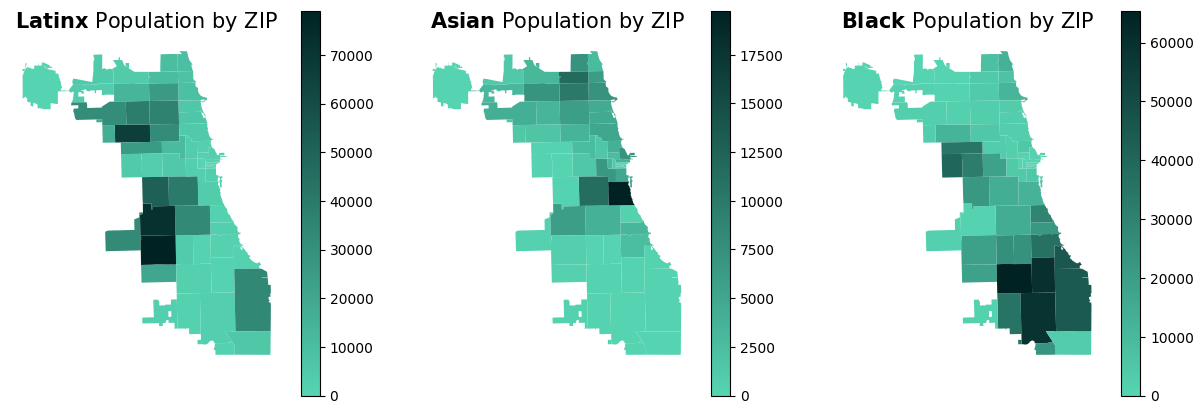

In [22]:
# Create custom colormap
colors = ['#56d4b2', '#002223']
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Create figure and axis
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot your GeoDataFrame with custom colormap
chicago.plot(column='Population - Latinx', ax=ax[0], legend=True, cmap=cmap)
chicago.plot(column='Population - Asian Non-Latinx', ax=ax[1], legend=True, cmap=cmap)
chicago.plot(column='Population - Black Non-Latinx', ax=ax[2], legend=True, cmap=cmap)
#chicago.plot(column='Proportion Non-White', ax=ax[1,1], legend=True, cmap=cmap)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
#ax[1,1].set_axis_off()

# Add title (optional)
ax[0].set_title(r'$\bf{Latinx}$ Population by ZIP', size=15)
ax[1].set_title(r'$\bf{Asian}$ Population by ZIP', size=15)
ax[2].set_title(r'$\bf{Black}$ Population by ZIP', size=15)
#ax[1,1].set_title('Proportion Non-White by ZIP')

plt.show()

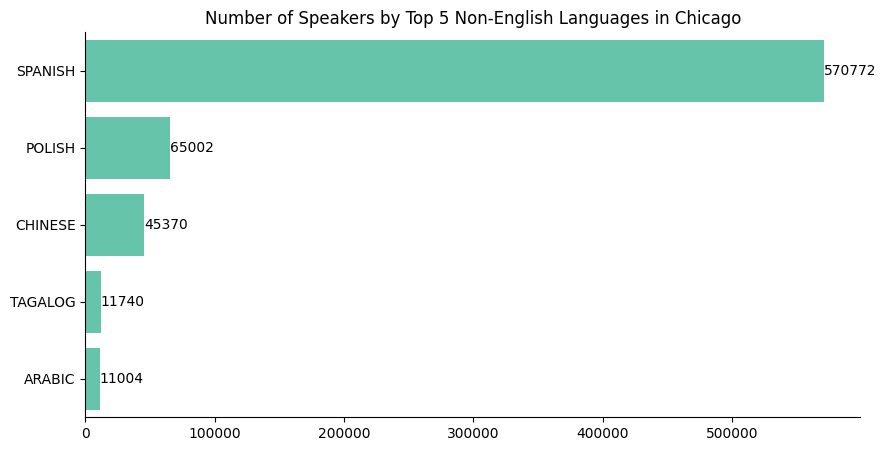

In [25]:
language_speakers = language_data.iloc[:,3:].apply(lambda col: sum(col))
language_speakers = language_speakers.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(language_speakers[0:5], ax=ax, orient='h', color='#56d4b2')
ax.set_title('Number of Speakers by Top 5 Non-English Languages in Chicago')
ax.bar_label(ax.containers[0],label_type='edge')
sns.despine()